In [ ]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp '/content/gdrive/My Drive/twitter-disaster-prediction-dataset-master/train.csv' './train.csv'

In [ ]:
tweet = pd.read_csv('/content/gdrive/My Drive/twitter-disaster-prediction-dataset-master/train.csv')

In [ ]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
tweet.shape

(7613, 5)

In [ ]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploratory Data Analysis

## Target Class Distribution

In [ ]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

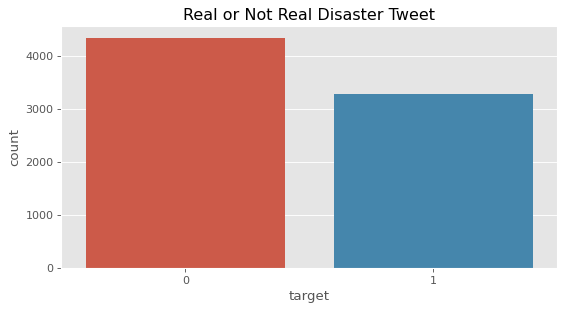

In [ ]:
sns.countplot('target', data = tweet)
plt.title('Real or Not Real Disaster Tweet')

In [ ]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

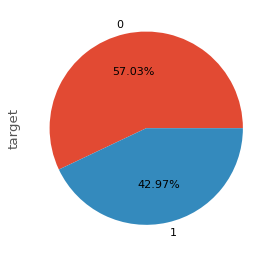

In [ ]:
tweet['target'].value_counts().plot.pie(autopct = '%1.2f%%')

## Number of Charaters Distribution in Tweets

In [ ]:
pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-sn9p_jix
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-sn9p_jix
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11756 sha256=3b2f6d01d2d669d00d3e2217bb02e647197892d50a52a617aa79e1030b2db378
  Stored in directory: /tmp/pip-ephem-wheel-cache-n3ynlbss/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [ ]:
import preprocess_kgptalkie as kgp

In [ ]:
tweet = kgp.get_basic_features(tweet)

In [ ]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


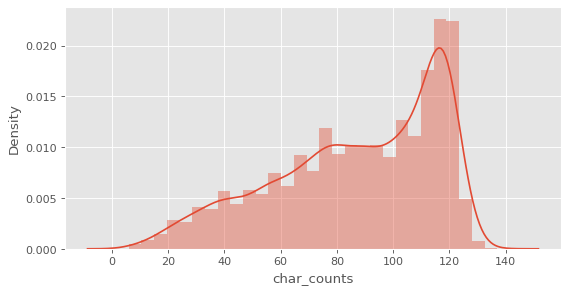

In [ ]:
sns.distplot(tweet['char_counts'])

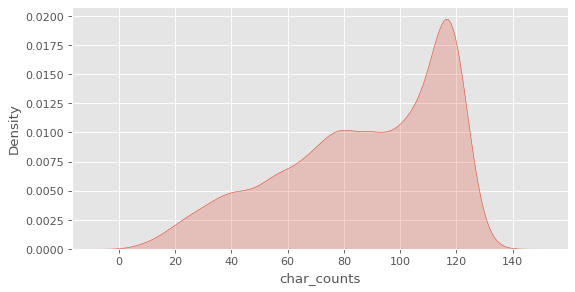

In [ ]:
sns.kdeplot(tweet['char_counts'], shade = True)

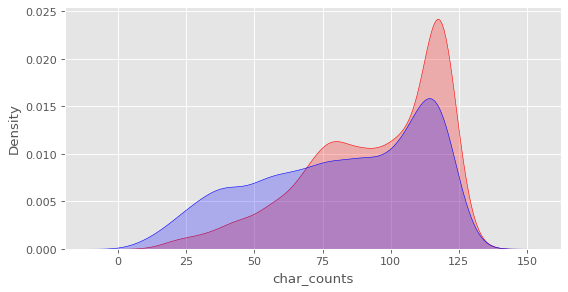

In [ ]:
sns.kdeplot(tweet[tweet['target'] == 1]['char_counts'], shade = True, color = 'red') #disaster
sns.kdeplot(tweet[tweet['target'] == 0]['char_counts'], shade = True, color = 'blue')

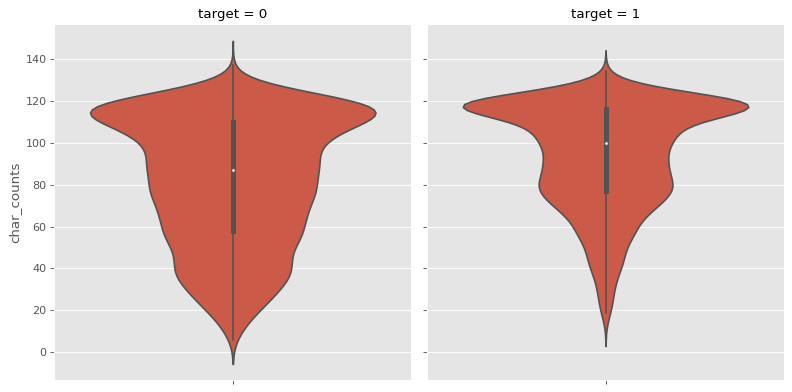

In [ ]:
sns.catplot(y = 'char_counts', data = tweet, kind = 'violin', col = 'target')

## Number of Words, Average Words Length, and Stop words Distibution in Tweets

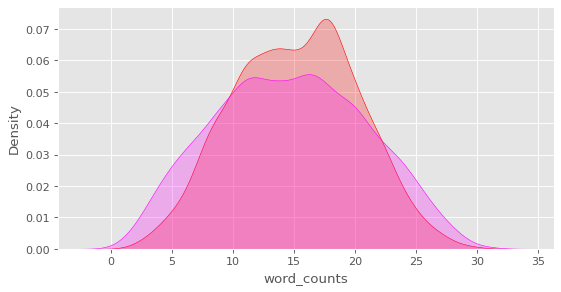

In [ ]:
sns.kdeplot(tweet[tweet['target'] == 1]['word_counts'], shade = True, color = 'red')
sns.kdeplot(tweet[tweet['target'] == 0]['word_counts'], shade = True, color = 'magenta')

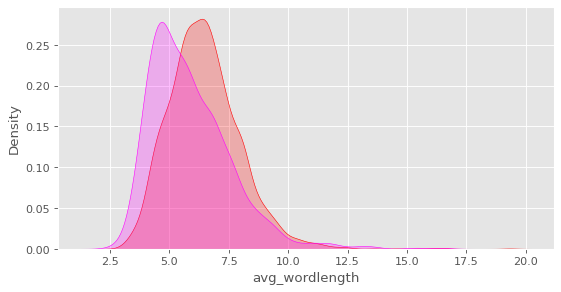

In [ ]:
sns.kdeplot(tweet[tweet['target'] == 1]['avg_wordlength'], shade = True, color = 'red')
sns.kdeplot(tweet[tweet['target'] == 0]['avg_wordlength'], shade = True, color = 'magenta')

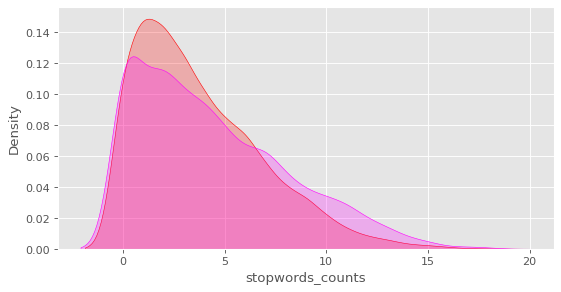

In [ ]:
sns.kdeplot(tweet[tweet['target'] == 1]['stopwords_counts'], shade = True, color = 'red')
sns.kdeplot(tweet[tweet['target'] == 0]['stopwords_counts'], shade = True, color = 'magenta')

In [ ]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

## Most and least common words

In [ ]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [ ]:
top20 = freqs[100:120]

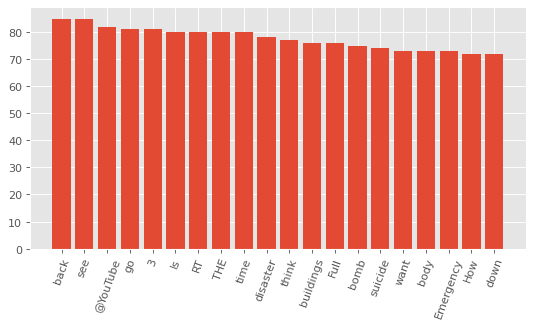

In [ ]:
plt.bar(top20.index, top20.values) #stop words are occuring the most
plt.xticks(rotation = 70)
plt.show()

In [ ]:
least20 = freqs[-20:]
least20 #No need to plot

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
dtype: int64

In [ ]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)
bigram[:20]

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492),
 ('ûóher upper', 68491),
 ('ûó wallybaiter', 68490),
 ('ûó the', 68489),
 ('ûó stories', 68488),
 ('ûó rt', 68487),
 ('ûó richmond', 68486),
 ('ûó organizers', 68485),
 ('ûó oh', 68484),
 ('ûó now', 68483),
 ('ûó lol', 68482),
 ('ûó integrates', 68481),
 ('ûó https', 68480),
 ('ûó hiroshima', 68479),
 ('ûó head', 68478),
 ('ûó eh', 68477),
 ('ûó desolation', 68476)]

One-Shot Data Cleaning

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [ ]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [ ]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
# kgp.get_ngram(tweet, 'text', ngram_range=2)

# Disaster Words Visualization with Word Cloud

In [ ]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire are was as have my news httpst over up more via disaster an were be people california suicide has no police who but when been killed like do 2 will just hiroshima than so out fires storm crash families we train now about into emergency s your buildings bomb there all what two mh370 attack am nuclear they wildfire video accident get new one bombing how prime minister northern burning legionnaires dead me bomber homes some if car war still atomic obama he fatal years off may us collapse forest retweet city watch debris malaysia first today 1 japan or man latest mass severe near water had earthquake before those confirmed found oil would down 70 spill floods army world home under warning 4 could injured wreckage weather derailment outbreak 3 evacuation being saudi thunderstorm migrants 40 our old flood missing flooding can during say investigators their time bridge back mosque death suspect state her cha

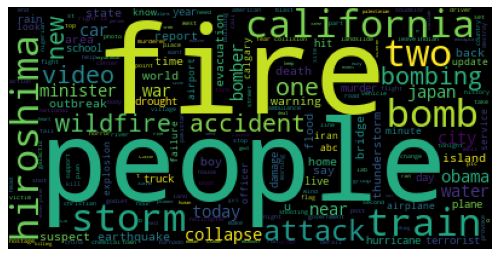

In [ ]:
word_cloud = WordCloud(max_font_size=100).generate(real) #already present in pandas
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

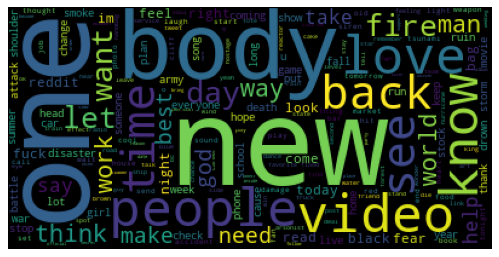

In [ ]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

# Classification with TFIDF and SVM

In [ ]:
text = tweet['text']
y = tweet['target']

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [ ]:
X.shape

(7613, 22545)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y) 

In [ ]:
def run_SVM(clr, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print()
    print('Classification Report')
    print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



# Classification with Word2Vec and SVM

In [ ]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 7.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import spacy
import en_core_web_lg

In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
x = 'cat dog'
doc = nlp(x)

In [ ]:
doc.vector.shape

(300,)

In [ ]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [ ]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [ ]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.8476947, 0.8888447, -3.10391, 0.090650745,..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.35491997, -1.5415528, -2.0926642, -0.49523..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-2.8959212, 0.6998072, -2.5640087, 1.2561336,..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-2.3889112, -0.6061475, -2.453201, 1.5150287,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.8628482, -0.2587669, -2.5594664, 0.3031685..."


In [ ]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [ ]:
X.shape

(7613, 1)

In [ ]:
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)

In [ ]:
X.shape

(7613, 300)

In [ ]:
y = tweet['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y) 

In [ ]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.71      0.95      0.81       869
           1       0.88      0.48      0.62       654

    accuracy                           0.75      1523
   macro avg       0.79      0.71      0.71      1523
weighted avg       0.78      0.75      0.73      1523

CPU times: user 6.26 s, sys: 35 ms, total: 6.29 s
Wall time: 6.34 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


# Word Embeddings and Classification with Deep Learning

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [ ]:
token = Tokenizer()
token.fit_on_texts(text)

In [ ]:
vocab_size = len(token.word_index) + 1
vocab_size

22581

In [ ]:
print(token.word_index)

{'httpt': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'i': 7, 'and': 8, 'is': 9, 'you': 10, 'for': 11, 'on': 12, 'it': 13, 'my': 14, 'not': 15, 'that': 16, 'with': 17, 'at': 18, 'by': 19, 'this': 20, 'have': 21, 'are': 22, 'from': 23, 'be': 24, 'was': 25, 'httpst': 26, 'do': 27, 'like': 28, 'as': 29, 'out': 30, 'am': 31, 'so': 32, 'your': 33, 'up': 34, 'me': 35, 'just': 36, 'but': 37, 'will': 38, 'after': 39, 'has': 40, 'all': 41, 'no': 42, 'fire': 43, 'an': 44, 'when': 45, 'if': 46, 'he': 47, 'new': 48, 'we': 49, 'get': 50, 'they': 51, 'now': 52, 'about': 53, 'via': 54, 'more': 55, 'people': 56, 'what': 57, 'or': 58, 'how': 59, 'one': 60, 'been': 61, 'there': 62, '2': 63, 'over': 64, 'news': 65, 'would': 66, 'who': 67, 'into': 68, 'were': 69, 'video': 70, 'can': 71, 'emergency': 72, 'disaster': 73, 'us': 74, 'police': 75, 'than': 76, 'off': 77, 'her': 78, 'some': 79, 'still': 80, 'his': 81, 'body': 82, 'back': 83, 'time': 84, 'burning': 85, 'california': 86, 'crash': 87, 'know': 8

In [ ]:
encoded_text = token.texts_to_sequences(text)

In [ ]:
print(encoded_text)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 372, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [ ]:
max_length = 40
X = pad_sequences(encoded_text, maxlen = max_length, padding = 'post')

In [ ]:
print(X)

[[ 109 4491   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2295 4483 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [ ]:
X.shape

(7613, 40)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y) 

In [ ]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.59      0.43      0.50       869
           1       0.44      0.60      0.51       654

    accuracy                           0.50      1523
   macro avg       0.51      0.51      0.50      1523
weighted avg       0.53      0.50      0.50      1523

CPU times: user 775 ms, sys: 13.9 ms, total: 789 ms
Wall time: 803 ms


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length = max_length))

model.add(Conv1D(32, 2, activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation = 'relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           2258100   
                                                                 
 conv1d (Conv1D)             (None, 39, 32)            6432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 32)            0         
                                                                 
 dense (Dense)               (None, 19, 32)            1056      
                                                                 
 dropout_1 (Dropout)         (None, 19, 32)            0         
                                                        

In [ ]:
%%time
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 5, validation_data = (X_test, y_test))

Epoch 1/5
191/191 [==============================] - 14s 9ms/step - loss: 0.6738 - accuracy: 0.5755 - val_loss: 0.6265 - val_accuracy: 0.7032
Epoch 2/5
191/191 [==============================] - 2s 9ms/step - loss: 0.5286 - accuracy: 0.7570 - val_loss: 0.4688 - val_accuracy: 0.8063
Epoch 3/5
191/191 [==============================] - 1s 8ms/step - loss: 0.3592 - accuracy: 0.8562 - val_loss: 0.4569 - val_accuracy: 0.7965
Epoch 4/5
191/191 [==============================] - 1s 8ms/step - loss: 0.2307 - accuracy: 0.9131 - val_loss: 0.4961 - val_accuracy: 0.7702
Epoch 5/5
191/191 [==============================] - 2s 8ms/step - loss: 0.1460 - accuracy: 0.9463 - val_loss: 0.5670 - val_accuracy: 0.7715
CPU times: user 13.2 s, sys: 2.32 s, total: 15.5 s
Wall time: 22 s


In [ ]:
def get_encoded(x):
    x = get_clean(x)
    # x = [x]
    x = token.texts_to_sequences([x])
    x = pad_sequences(x, maxlen = max_length, padding = 'post')
    return x

In [ ]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [ ]:
np.argmax(model.predict(vec), axis = -1)

array([0])

# Bert Model Building and Training

In [ ]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 68.8 MB/s 
     |████████████████████████████████| 981 kB 49.4 MB/s 
     |████████████████████████████████| 263 kB 52.5 MB/s 
     |████████████████████████████████| 3.8 MB 38.7 MB/s 
     |████████████████████████████████| 1.3 MB 53.7 MB/s 
     |████████████████████████████████| 468 kB 44.0 MB/s 
     |████████████████████████████████| 6.6 MB 38.9 MB/s 
     |████████████████████████████████| 880 kB 52.0 MB/s 
     |████████████████████████████████| 101 kB 12.0 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.7-py3-none-any.whl size=25312842 sha256=a0dd3c3591ce26ff1989c18279da01ce4d54935370bfdb975f667a017a0cf08c
  Stored in directory: /root/.cache/pip/wheels/e5/98/8e/ce355dcb92451e85fab93f7ea2da068843e93e703928cd06fb
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=c057e2ef72cffe0c0873b14

In [ ]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.8476947, 0.8888447, -3.10391, 0.090650745,..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.35491997, -1.5415528, -2.0926642, -0.49523..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-2.8959212, 0.6998072, -2.5640087, 1.2561336,..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-2.3889112, -0.6061475, -2.453201, 1.5150287,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.8628482, -0.2587669, -2.5594664, 0.3031685..."


In [ ]:
from ktrain import text
import ktrain

In [ ]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df = tweet, text_column = 'text', label_columns = 'target', maxlen = 40, preprocess_mode = 'bert') #validation by default is 10%

['not_target', 'target']
      not_target  target
1656         1.0     0.0
5270         0.0     1.0
3345         0.0     1.0
3983         1.0     0.0
2496         1.0     0.0
['not_target', 'target']
      not_target  target
2084         0.0     1.0
2782         0.0     1.0
8            0.0     1.0
6234         0.0     1.0
6162         1.0     0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = text.text_classifier(name = 'bert', train_data = (X_train, y_train), preproc = preproc)

Is Multi-Label? False
maxlen is 40
done.


In [ ]:
learner = ktrain.get_learner(model = model, train_data = (X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [ ]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 108s 464ms/step - loss: 0.4871 - accuracy: 0.7739 - val_loss: 0.4040 - val_accuracy: 0.8268


In [ ]:
learner.fit_onecycle(lr = 2e-4, epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 41s 377ms/step - loss: 0.3848 - accuracy: 0.8380 - val_loss: 0.5093 - val_accuracy: 0.8045
Epoch 2/3
108/108 [==============================] - 40s 375ms/step - loss: 0.3321 - accuracy: 0.8724 - val_loss: 0.4085 - val_accuracy: 0.8176
Epoch 3/3
108/108 [==============================] - 40s 372ms/step - loss: 0.1725 - accuracy: 0.9368 - val_loss: 0.5224 - val_accuracy: 0.8241


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
108/108 [==============================] - 39s 362ms/step - loss: 0.0863 - accuracy: 0.9708
Epoch 2/1024
108/108 [==============================] - 37s 344ms/step - loss: 0.0835 - accuracy: 0.9721
Epoch 3/1024
108/108 [==============================] - 37s 345ms/step - loss: 0.0821 - accuracy: 0.9720
Epoch 4/1024
108/108 [==============================] - 37s 344ms/step - loss: 0.0743 - accuracy: 0.9733
Epoch 5/1024
108/108 [==============================] - 37s 344ms/step - loss: 0.0661 - accuracy: 0.9756
Epoch 6/1024
108/108 [==============================] - 37s 344ms/step - loss: 0.0622 - accuracy: 0.9772
Epoch 7/1024
108/108 [==============================] - 37s 344ms/step - loss: 0.1254 - accuracy: 0.9537
Epoch 8/1024
108/108 [==============================] - 33s 308ms/step - loss: 0.2986 - accuracy: 0.8740


done.
Please invoke the Learner.lr_plot() method to visually inspect the lo

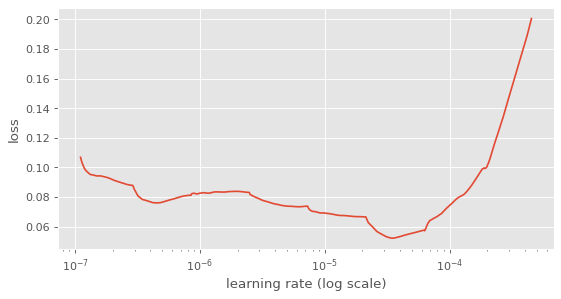

In [ ]:
#found the best learning rate
learner.lr_find()
learner.lr_plot()

#could take hours to days

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
data = ['I met you today by accident', 'I got in a car accident today, I am injured']

In [ ]:
predictor.predict(data, return_proba=True)

array([[0.9907252 , 0.00927479],
       [0.01408526, 0.9859147 ]], dtype=float32)

In [ ]:
predictor.predict(data[0])

'not_target'

In [ ]:
predictor.predict(data[1])

'target'

In [ ]:
classes = predictor.get_classes()

In [ ]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

1

In [ ]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)